In [1]:
import os, re, glob
import pandas as pd


file = ["business","entertainment", "politics", "sport", "tech"]


alltext = []
alltitle = []
allfilename = []
allcategory = []

for k in file:
    print(k)
  
    filenames = sorted(glob.glob("./bbc/"+ k +"/*.txt"))
    N = len(filenames)
    print(N)

    filenames = filenames[:N]
    for f in filenames:
        f_id = re.findall("\d+", f)[0] + ".txt"

        df = pd.read_table(f, header=None, index_col=False)
        title = df.iloc[0][0]

        df = df.iloc[1: , :]
        text = []
        for i in range(len(df)):
            text.append(df.iloc[i][0])

        alltext.append(str(text)[1:])
        alltitle.append(str(title))
        allfilename.append(f_id)
        allcategory.append(k)

alldata = pd.DataFrame.from_dict({"filename":allfilename, "title":alltitle, "text":alltext,"category":allcategory})
alldata.to_csv("./bbc_news_all_category.txt", sep=" ", index=False)

business
510
entertainment
386
politics
417
sport
511
tech
401


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [3]:
max_words = 5000
embedding_dim = 100
maxlen = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [4]:
import pandas as pd 

df = pd.read_csv("./bbc_news_all_category.txt",  sep=" ")
df.head()

,filename,title,text,category
0,001.txt,Ad sales boost Time Warner profit,'Quarterly profits at US media giant TimeWarne...,business
1,002.txt,Dollar gains on Greenspan speech,'The dollar has hit its highest level against ...,business
2,003.txt,Yukos unit buyer faces loan claim,'The owners of embattled Russian oil giant Yuk...,business
3,004.txt,High fuel prices hit BA's profits,'British Airways has blamed high fuel prices f...,business
4,005.txt,Pernod takeover talk lifts Domecq,"""Shares in UK drinks and food firm Allied Dome...",business


In [5]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df["labels"] = labelencoder.fit_transform(df.category)
df.drop(["category"], axis=1, inplace=True)

In [7]:
df.head()

,filename,title,text,labels
0,001.txt,Ad sales boost Time Warner profit,'Quarterly profits at US media giant TimeWarne...,0
1,002.txt,Dollar gains on Greenspan speech,'The dollar has hit its highest level against ...,0
2,003.txt,Yukos unit buyer faces loan claim,'The owners of embattled Russian oil giant Yuk...,0
3,004.txt,High fuel prices hit BA's profits,'British Airways has blamed high fuel prices f...,0
4,005.txt,Pernod takeover talk lifts Domecq,"""Shares in UK drinks and food firm Allied Dome...",0


In [8]:
df.labels.value_counts()

3    511
0    510
2    417
4    401
1    386
Name: labels, dtype: int64

In [9]:
#df["text"] = df.title + df.text

In [10]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
import nltk

def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
    return " ".join(result)


In [11]:
processed_docs = df['text'].map(preprocess)
df['cleaned_text'] = processed_docs

In [12]:
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_tok)
tokenizer.fit_on_texts(df.cleaned_text)
sequences = tokenizer.texts_to_sequences(df.cleaned_text)
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 21397 unique tokens.


In [13]:
from keras.preprocessing import text, sequence
from keras.utils.np_utils import to_categorical

data = pad_sequences(sequences, maxlen=maxlen, padding=padding_type, truncating=trunc_type)
labels = to_categorical(np.asarray(df.labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (2225, 200)
Shape of label tensor: (2225, 5)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1780, 200) (1780, 5)
(445, 200) (445, 5)


In [15]:
max_words=len(word_index)

In [16]:
embeddings_index = {}
with open('../../chapter-4/glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((max_words+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2139800   
_________________________________________________________________
dropout (Dropout)            (None, 200, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 6

In [18]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), verbose=2)

Epoch 1/15
56/56 - 11s - loss: 0.9882 - accuracy: 0.6292 - val_loss: 0.4456 - val_accuracy: 0.8562
Epoch 2/15
56/56 - 8s - loss: 0.3342 - accuracy: 0.9000 - val_loss: 0.2704 - val_accuracy: 0.9191
Epoch 3/15
56/56 - 8s - loss: 0.2128 - accuracy: 0.9331 - val_loss: 0.1526 - val_accuracy: 0.9438
Epoch 4/15
56/56 - 8s - loss: 0.1344 - accuracy: 0.9624 - val_loss: 0.2127 - val_accuracy: 0.9326
Epoch 5/15
56/56 - 9s - loss: 0.1623 - accuracy: 0.9506 - val_loss: 0.1813 - val_accuracy: 0.9393
Epoch 6/15
56/56 - 9s - loss: 0.1458 - accuracy: 0.9551 - val_loss: 0.2556 - val_accuracy: 0.9258
Epoch 7/15
56/56 - 8s - loss: 0.1351 - accuracy: 0.9646 - val_loss: 0.1781 - val_accuracy: 0.9551
Epoch 8/15
56/56 - 8s - loss: 0.0921 - accuracy: 0.9691 - val_loss: 0.2148 - val_accuracy: 0.9416
Epoch 9/15
56/56 - 8s - loss: 0.0932 - accuracy: 0.9730 - val_loss: 0.2470 - val_accuracy: 0.9393
Epoch 10/15
56/56 - 8s - loss: 0.1077 - accuracy: 0.9612 - val_loss: 0.1696 - val_accuracy: 0.9483
Epoch 11/15
56/56 

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Eğitimin Başarımı')
    plt.plot(x, val_acc, 'r', label='Doğrulama Başarımı')
    plt.title('Eğitim ve Doğrulama Başarımı')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Eğitim kaybı')
    plt.plot(x, val_loss, 'r', label='Doğrulama kaybı')
    plt.title('Eğitim ve Doğrulama Kaybı')
    plt.legend()
    plt.show()

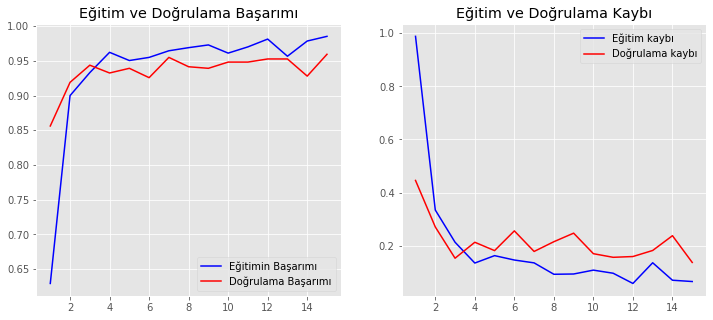

In [20]:
plot_history(history)

In [21]:
loss, acc = model.evaluate(X_test, y_test)
print('Test score:', loss)
print('Test accuracy:', acc)
--> Test score: 0.13670197129249573
--> Test accuracy: 0.9595505595207214

14/14 [==============================] - 1s 61ms/step - loss: 0.1367 - accuracy: 0.9596
Test score: 0.13670197129249573
Test accuracy: 0.9595505595207214


In [22]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class

array([0, 4, 2, 3, 2, 2, 2, 4, 2, 3, 3, 1, 0, 3, 2, 3, 0, 0, 3, 4, 1, 2,
       0, 4, 4, 4, 1, 0, 0, 0, 0, 3, 3, 3, 2, 0, 1, 3, 2, 2, 4, 4, 1, 1,
       2, 0, 4, 0, 0, 0, 0, 3, 0, 2, 4, 4, 3, 4, 0, 4, 0, 3, 2, 4, 3, 1,
       2, 0, 3, 2, 1, 3, 4, 2, 3, 3, 2, 2, 2, 2, 0, 1, 3, 0, 4, 4, 4, 0,
       1, 0, 0, 1, 0, 0, 1, 2, 3, 3, 2, 1, 3, 4, 2, 3, 1, 3, 1, 2, 0, 0,
       2, 1, 0, 1, 1, 2, 3, 1, 4, 2, 1, 3, 4, 4, 1, 4, 3, 0, 3, 2, 3, 3,
       1, 2, 0, 0, 1, 1, 2, 2, 3, 1, 2, 0, 2, 0, 3, 0, 2, 0, 4, 1, 2, 3,
       4, 0, 2, 1, 4, 3, 0, 2, 1, 0, 3, 3, 0, 1, 0, 0, 0, 3, 1, 2, 3, 3,
       4, 0, 0, 1, 3, 4, 3, 4, 3, 0, 4, 0, 3, 0, 3, 0, 0, 1, 2, 1, 0, 2,
       2, 2, 0, 1, 3, 4, 3, 0, 2, 4, 4, 0, 0, 4, 0, 0, 3, 3, 2, 0, 2, 3,
       0, 0, 4, 0, 1, 3, 0, 0, 0, 4, 1, 3, 1, 0, 1, 0, 0, 4, 4, 1, 0, 4,
       2, 2, 4, 3, 3, 3, 3, 0, 1, 0, 0, 1, 3, 3, 1, 2, 4, 3, 0, 0, 3, 2,
       2, 4, 3, 3, 4, 4, 1, 0, 2, 4, 0, 2, 1, 2, 2, 0, 3, 2, 1, 2, 0, 1,
       2, 4, 4, 1, 0, 1, 4, 2, 3, 4, 0, 0, 0, 4, 3,

In [23]:
_class = np.argmax(y_test, axis=1)

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print('Accuracy for LogisticRegression: %.2f' % accuracy_score(_class, y_pred_class))
print(classification_report(_class, y_pred_class)) #target_names=my_tags

Accuracy for LogisticRegression: 0.96
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       111
           1       0.96      0.97      0.97        74
           2       0.99      0.93      0.96        86
           3       1.00      0.99      1.00       108
           4       0.91      0.94      0.93        66

    accuracy                           0.96       445
   macro avg       0.96      0.96      0.96       445
weighted avg       0.96      0.96      0.96       445



In [25]:
confusion_matrix(_class, y_pred_class)

array([[106,   1,   1,   0,   3],
       [  1,  72,   0,   0,   1],
       [  3,   1,  80,   0,   2],
       [  1,   0,   0, 107,   0],
       [  3,   1,   0,   0,  62]])

In [26]:
df.cleaned_text

0       quarterly profit media giant timewarner jump m...
1       dollar highest level euro months federal reser...
2       owners embattle russian giant yukos buyer prod...
3       british airways blame high fuel price drop pro...
4       share drink food firm ally domecq rise specula...
                              ...                        
2220    introduce initiatives help beat rogue dialler ...
2221    users world continue ignore security warn spam...
2222    european directive software writers risk legal...
2223    make sure network safe secure resign year post...
2224    online role play game time consume enthral fli...
Name: cleaned_text, Length: 2225, dtype: object

In [27]:
sentences = [row.split() for row in df['cleaned_text']]

In [28]:
from collections import defaultdict

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

21396

In [29]:
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)

In [30]:
w2v_model.build_vocab(sentences)

In [31]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(660296, 1960565)

In [32]:
w2v_model.init_sims(replace=True)

In [33]:
w2v_model.wv.most_similar(positive=['state'])

[('countries', 0.9465482234954834),
 ('commission', 0.9437171220779419),
 ('foreign', 0.9341842532157898),
 ('investment', 0.932471752166748),
 ('raise', 0.9297500848770142),
 ('fund', 0.9263367652893066),
 ('agree', 0.9245710968971252),
 ('order', 0.9210283160209656),
 ('warn', 0.920039176940918),
 ('president', 0.9196850061416626)]

In [34]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


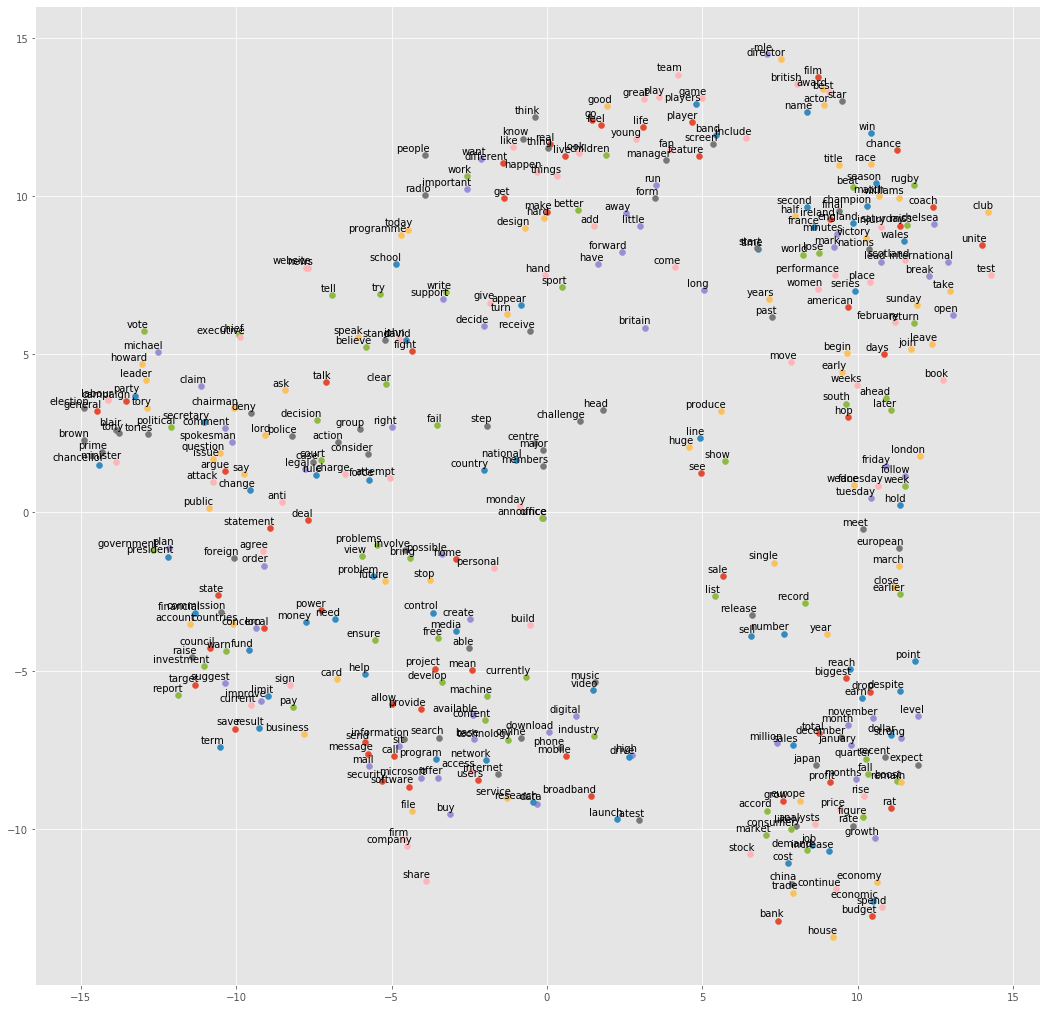

In [35]:
tsne_plot(w2v_model)